# Introduction
Classifying Chest X-Ray Images using Transfer Learning in Tensorflow

According to the World Health Organization (WHO), pneumonia kills about 2 million children under 5 years old every year and is consistently estimated as the single leading cause of childhood mortality [Ruden et al., 2008](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5#bib15). It is especially an issue in developing countries where immediate treatment is needed but rapid radiological interpretation is not always available. Therefore an accurate CNN model which provides rapid results can be very beneficial in these areas where diagnosis is not as timely.

Dataset used for this project can be found [here](https://data.mendeley.com/datasets/rscbjbr9sj/2).

The data  consists of 5,856 X-Ray Images labeled as 'Normal', 'Bacterial Pneumonia', or 'Viral Pneumonia'. The dataset is broken down into a testing, validation, and training set.

For this project the following will be covered:

1. Load the images and convert images to an array to use in CNN Models. The images will be resized to 128x128 pixels and all array values will be scaled between 0 and 1. Images will be split into training and testing sets (80% training and 20% testing)

2. First a base CNN model will be created that contains 2 dense layers. 

3. Next we will add to this base CNN model be adding Regularization (where 30% of the data will drop out between layers).

4. Next we will continue to add to this model by Augmenting the images. Image augmentation  will include X and Y shifting, zooming, and horizontal image flipping.

5. Finally we will explore two different Transfer Learning models (VGG-16 and MobileNet) to see if we can improve the results by using pretrained models and adding our own new dense layers on top.

In all cases we will record accuracy and loss values to help us determine where models are overfitting and which models perform the best. We will also review  recall and precision scores to see how the model performs on data it has not yet seen.

## Set Up Environment

In [3]:
# Needed for installing opencv (saving for laptop)
#!pip install opencv-contrib-python
#!conda install opencv-contrib-python

In [19]:
# General
import os
import numpy as np
import pandas as pd
import random
import seaborn as sns
# sets matplotlib to inline and displays graphs below the corressponding cell
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import style
from PIL import Image
from tqdm import tqdm # Adds progress bar in for loops
import cv2

# SKLearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, InputLayer
from tensorflow.keras import optimizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16

## Set Up Directory

In [5]:
os.chdir('D:/Thinkful Data Science/Data Sets/Chest Xrays/Chest Xrays')
print(os.listdir())

['Normal', 'Pneumonia']


In [6]:
normal_directory = './Normal/'
pneumonia_directory = './Pneumonia/'
print(len(os.listdir(normal_directory))) # Number of img in normal directory
print(len(os.listdir(pneumonia_directory))) # Number of img in pneumonia directory

1583
4273


Let's take a look at some of the images as a starting point

Normal Picture Title:  NORMAL2-IM-0824-0001.jpeg
Pneumonia Picture Title:  person491_bacteria_2071.jpeg


Text(0.5, 1.0, 'Pneumonia')

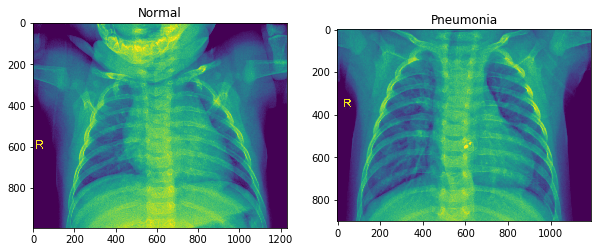

In [7]:
#Normal pic 
normal_pic = (os.listdir(normal_directory))[np.random.randint(0,len(os.listdir(normal_directory)))] # Random image from directory
print('Normal Picture Title: ' , normal_pic)
normal_pic_address = normal_directory + normal_pic

#Pneumonia pic
pneumonia_pic = (os.listdir(pneumonia_directory))[np.random.randint(0,len(os.listdir(pneumonia_directory)))] # Random image from directory
print('Pneumonia Picture Title: ' , pneumonia_pic)
pneumonia_pic_address = pneumonia_directory + pneumonia_pic

# Load the images
normal_load = Image.open(normal_pic_address)
pneumonia_load = Image.open(pneumonia_pic_address)

#Let's plt these images
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(normal_load)
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(pneumonia_load)
a2.set_title('Pneumonia')

## Apply  Labels to Images and Reshape Images

Here we will create arrays for each image. X will contain the image data and Y will contain the label for the corresponding image. We will only differentiate between X-Rays which depict a 'Normal' case and X-Rays which depect a 'Pneumonia' case.

In [8]:
X=[]
y=[]
img_size = 128

for img in tqdm(os.listdir(normal_directory)):
    label = 'Normal'
    path = os.path.join(normal_directory,img)
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_size,img_size))

    X.append(np.array(img))
    y.append(str(label))

100%|██████████████████████████████████████████████████████████████████████████████| 1583/1583 [00:52<00:00, 29.88it/s]


In [9]:
for img in tqdm(os.listdir(pneumonia_directory)):
    label = 'Pneumonia'
    path = os.path.join(pneumonia_directory,img)
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_size,img_size))

    X.append(np.array(img))
    y.append(str(label))

100%|██████████████████████████████████████████████████████████████████████████████| 4273/4273 [01:05<00:00, 65.43it/s]


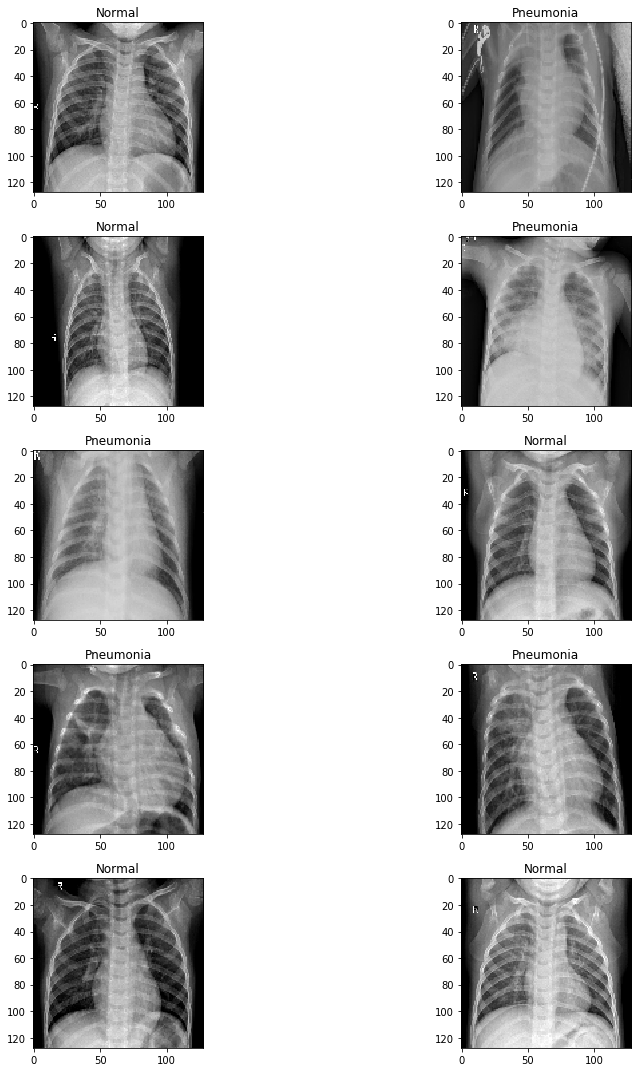

In [10]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=np.random.randint(0,len(y))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title(y[l])
        
plt.tight_layout()

## Scale data between 0 and 1

Here we convert the labels to categorical and scale the images between 0 and 1.

In [11]:
labelEncoder=LabelEncoder()
y=labelEncoder.fit_transform(y)
y=to_categorical(y,2)
X=np.array(X)
X=X/255

In [12]:
X.shape

(5856, 128, 128, 3)

In [13]:
y.shape

(5856, 2)

The data is now split into 80% training and 20% testing sets

In [14]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=13)

In [15]:
X_train.shape

(4684, 128, 128, 3)

In [16]:
X_test.shape

(1172, 128, 128, 3)

In [17]:
y_train.shape

(4684, 2)

In [18]:
y_test.shape

(1172, 2)

# Base CNN Model

## CNN Model
First basic model will use 2 dense layers

In [19]:
batch_size = 64
num_classes =  2
epochs = 20
input_shape = (128, 128, 3)

model = Sequential()

# Add three convolutional layers for feature extraction
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the layer
model.add(Flatten())

# our first dense layer
model.add(Dense(512, activation='relu'))

# our output layer
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='sgd', loss='categorical_crossentropy',
            metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0

In [20]:
history = model.fit(x=X_train, y=y_train,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 4684 samples, validate on 1172 samples
Epoch 1/20
4684/4684 [==============================] - ETA: 1:37 - loss: 0.6778 - accuracy: 0.65 - ETA: 1:02 - loss: 0.6572 - accuracy: 0.68 - ETA: 50s - loss: 0.6490 - accuracy: 0.6875 - ETA: 43s - loss: 0.6392 - accuracy: 0.695 - ETA: 39s - loss: 0.6322 - accuracy: 0.700 - ETA: 36s - loss: 0.6286 - accuracy: 0.703 - ETA: 34s - loss: 0.6133 - accuracy: 0.718 - ETA: 32s - loss: 0.6087 - accuracy: 0.720 - ETA: 31s - loss: 0.6077 - accuracy: 0.720 - ETA: 30s - loss: 0.6048 - accuracy: 0.721 - ETA: 29s - loss: 0.6032 - accuracy: 0.721 - ETA: 28s - loss: 0.6021 - accuracy: 0.721 - ETA: 27s - loss: 0.6002 - accuracy: 0.722 - ETA: 26s - loss: 0.5993 - accuracy: 0.722 - ETA: 26s - loss: 0.5957 - accuracy: 0.725 - ETA: 25s - loss: 0.5912 - accuracy: 0.728 - ETA: 24s - loss: 0.5925 - accuracy: 0.727 - ETA: 24s - loss: 0.5841 - accuracy: 0.735 - ETA: 23s - loss: 0.5846 - accuracy: 0.735 - ETA: 22s - loss: 0.5835 - accuracy: 0.735 - ETA: 22s - loss

4684/4684 [==============================] - ETA: 27s - loss: 0.2408 - accuracy: 0.921 - ETA: 26s - loss: 0.2336 - accuracy: 0.906 - ETA: 26s - loss: 0.2509 - accuracy: 0.911 - ETA: 25s - loss: 0.2392 - accuracy: 0.914 - ETA: 25s - loss: 0.2326 - accuracy: 0.918 - ETA: 25s - loss: 0.2516 - accuracy: 0.901 - ETA: 24s - loss: 0.2643 - accuracy: 0.890 - ETA: 24s - loss: 0.2789 - accuracy: 0.888 - ETA: 23s - loss: 0.2837 - accuracy: 0.883 - ETA: 23s - loss: 0.2768 - accuracy: 0.884 - ETA: 23s - loss: 0.2839 - accuracy: 0.882 - ETA: 22s - loss: 0.2803 - accuracy: 0.882 - ETA: 22s - loss: 0.2775 - accuracy: 0.881 - ETA: 22s - loss: 0.2752 - accuracy: 0.881 - ETA: 21s - loss: 0.2734 - accuracy: 0.882 - ETA: 21s - loss: 0.2735 - accuracy: 0.884 - ETA: 20s - loss: 0.2705 - accuracy: 0.887 - ETA: 20s - loss: 0.2682 - accuracy: 0.889 - ETA: 20s - loss: 0.2611 - accuracy: 0.893 - ETA: 19s - loss: 0.2577 - accuracy: 0.895 - ETA: 19s - loss: 0.2571 - accuracy: 0.895 - ETA: 19s - loss: 0.2553 - accur

4684/4684 [==============================] - ETA: 26s - loss: 0.2832 - accuracy: 0.875 - ETA: 26s - loss: 0.2515 - accuracy: 0.890 - ETA: 25s - loss: 0.2827 - accuracy: 0.890 - ETA: 25s - loss: 0.2546 - accuracy: 0.906 - ETA: 25s - loss: 0.2355 - accuracy: 0.909 - ETA: 24s - loss: 0.2268 - accuracy: 0.916 - ETA: 24s - loss: 0.2158 - accuracy: 0.924 - ETA: 24s - loss: 0.2142 - accuracy: 0.921 - ETA: 23s - loss: 0.1994 - accuracy: 0.927 - ETA: 23s - loss: 0.2110 - accuracy: 0.923 - ETA: 23s - loss: 0.2060 - accuracy: 0.924 - ETA: 22s - loss: 0.2015 - accuracy: 0.928 - ETA: 22s - loss: 0.2063 - accuracy: 0.924 - ETA: 21s - loss: 0.2046 - accuracy: 0.926 - ETA: 21s - loss: 0.2045 - accuracy: 0.926 - ETA: 21s - loss: 0.2035 - accuracy: 0.925 - ETA: 20s - loss: 0.2015 - accuracy: 0.926 - ETA: 20s - loss: 0.1976 - accuracy: 0.928 - ETA: 20s - loss: 0.1937 - accuracy: 0.930 - ETA: 19s - loss: 0.1924 - accuracy: 0.932 - ETA: 19s - loss: 0.1888 - accuracy: 0.932 - ETA: 19s - loss: 0.1884 - accur

4684/4684 [==============================] - ETA: 26s - loss: 0.2451 - accuracy: 0.937 - ETA: 26s - loss: 0.2110 - accuracy: 0.945 - ETA: 25s - loss: 0.1770 - accuracy: 0.953 - ETA: 25s - loss: 0.1872 - accuracy: 0.945 - ETA: 25s - loss: 0.1770 - accuracy: 0.943 - ETA: 24s - loss: 0.1561 - accuracy: 0.950 - ETA: 24s - loss: 0.1601 - accuracy: 0.946 - ETA: 24s - loss: 0.1556 - accuracy: 0.947 - ETA: 23s - loss: 0.1483 - accuracy: 0.947 - ETA: 23s - loss: 0.1532 - accuracy: 0.946 - ETA: 23s - loss: 0.1510 - accuracy: 0.946 - ETA: 22s - loss: 0.1497 - accuracy: 0.947 - ETA: 22s - loss: 0.1545 - accuracy: 0.944 - ETA: 21s - loss: 0.1535 - accuracy: 0.944 - ETA: 21s - loss: 0.1490 - accuracy: 0.946 - ETA: 21s - loss: 0.1493 - accuracy: 0.947 - ETA: 20s - loss: 0.1488 - accuracy: 0.946 - ETA: 20s - loss: 0.1496 - accuracy: 0.946 - ETA: 20s - loss: 0.1542 - accuracy: 0.942 - ETA: 19s - loss: 0.1650 - accuracy: 0.937 - ETA: 19s - loss: 0.1645 - accuracy: 0.937 - ETA: 18s - loss: 0.1654 - accur

4684/4684 [==============================] - ETA: 26s - loss: 0.2899 - accuracy: 0.875 - ETA: 26s - loss: 0.2035 - accuracy: 0.914 - ETA: 25s - loss: 0.1746 - accuracy: 0.921 - ETA: 25s - loss: 0.1707 - accuracy: 0.921 - ETA: 25s - loss: 0.1641 - accuracy: 0.918 - ETA: 24s - loss: 0.1619 - accuracy: 0.921 - ETA: 24s - loss: 0.1599 - accuracy: 0.921 - ETA: 24s - loss: 0.1606 - accuracy: 0.925 - ETA: 23s - loss: 0.1610 - accuracy: 0.927 - ETA: 23s - loss: 0.1503 - accuracy: 0.934 - ETA: 22s - loss: 0.1442 - accuracy: 0.936 - ETA: 22s - loss: 0.1447 - accuracy: 0.936 - ETA: 22s - loss: 0.1471 - accuracy: 0.935 - ETA: 21s - loss: 0.1506 - accuracy: 0.934 - ETA: 21s - loss: 0.1486 - accuracy: 0.937 - ETA: 21s - loss: 0.1490 - accuracy: 0.937 - ETA: 20s - loss: 0.1467 - accuracy: 0.939 - ETA: 20s - loss: 0.1470 - accuracy: 0.940 - ETA: 20s - loss: 0.1452 - accuracy: 0.941 - ETA: 19s - loss: 0.1453 - accuracy: 0.940 - ETA: 19s - loss: 0.1438 - accuracy: 0.940 - ETA: 18s - loss: 0.1480 - accur

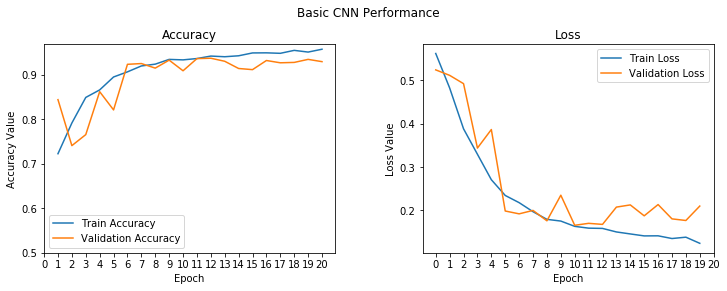

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,21))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 21, 1))
ax1.set_yticks(np.arange(.5, 1, .1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 21, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [23]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.20976334672942504
Test accuracy: 0.92918086


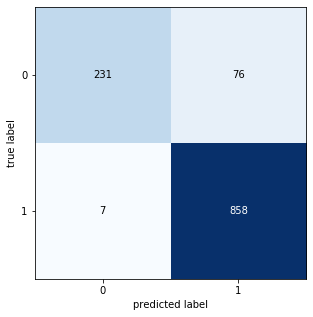

In [24]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)
CM = confusion_matrix(y_true, pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [25]:
# Precision Score
# precision = True Positive / (True Positive + False Positive)
print ("Precision Score: {}".format(CM[1][1] / (CM[1][1] + CM[0][1])))

# Recall Score
# recall = True Positive / (True Positive + False Negative)
print ("Recall Score: {}".format(CM[1][1] / (CM[1][1] + CM[1][0])))

Precision Score: 0.9186295503211992
Recall Score: 0.991907514450867


Summary:

- Validation Accuracy after 20 epochs: 91.8%
- Precision Score: 91.9%
- Recall Score: 99.1 %

## CNN Model with Regularization

In [26]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))


model.compile(optimizer='sgd', loss='categorical_crossentropy',
            metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        9280      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 128)      

In [27]:
history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test),batch_size=batch_size, epochs=epochs, verbose=1)

Train on 4684 samples, validate on 1172 samples
Epoch 1/20
4684/4684 [==============================] - ETA: 1:26 - loss: 0.7020 - accuracy: 0.45 - ETA: 58s - loss: 0.6910 - accuracy: 0.5469 - ETA: 48s - loss: 0.6861 - accuracy: 0.588 - ETA: 42s - loss: 0.6806 - accuracy: 0.605 - ETA: 39s - loss: 0.6786 - accuracy: 0.618 - ETA: 36s - loss: 0.6685 - accuracy: 0.645 - ETA: 35s - loss: 0.6617 - accuracy: 0.658 - ETA: 33s - loss: 0.6555 - accuracy: 0.669 - ETA: 32s - loss: 0.6542 - accuracy: 0.675 - ETA: 31s - loss: 0.6545 - accuracy: 0.671 - ETA: 30s - loss: 0.6500 - accuracy: 0.677 - ETA: 29s - loss: 0.6422 - accuracy: 0.690 - ETA: 28s - loss: 0.6392 - accuracy: 0.692 - ETA: 27s - loss: 0.6355 - accuracy: 0.698 - ETA: 27s - loss: 0.6355 - accuracy: 0.696 - ETA: 26s - loss: 0.6314 - accuracy: 0.700 - ETA: 25s - loss: 0.6317 - accuracy: 0.698 - ETA: 25s - loss: 0.6333 - accuracy: 0.695 - ETA: 24s - loss: 0.6284 - accuracy: 0.700 - ETA: 24s - loss: 0.6256 - accuracy: 0.703 - ETA: 23s - loss

4684/4684 [==============================] - ETA: 29s - loss: 0.5030 - accuracy: 0.734 - ETA: 28s - loss: 0.4564 - accuracy: 0.820 - ETA: 28s - loss: 0.4742 - accuracy: 0.781 - ETA: 27s - loss: 0.4756 - accuracy: 0.785 - ETA: 27s - loss: 0.4593 - accuracy: 0.784 - ETA: 27s - loss: 0.4583 - accuracy: 0.799 - ETA: 26s - loss: 0.4552 - accuracy: 0.817 - ETA: 26s - loss: 0.4524 - accuracy: 0.812 - ETA: 26s - loss: 0.4458 - accuracy: 0.822 - ETA: 25s - loss: 0.4257 - accuracy: 0.829 - ETA: 25s - loss: 0.4247 - accuracy: 0.823 - ETA: 24s - loss: 0.4227 - accuracy: 0.826 - ETA: 24s - loss: 0.4141 - accuracy: 0.831 - ETA: 23s - loss: 0.4180 - accuracy: 0.824 - ETA: 23s - loss: 0.4359 - accuracy: 0.809 - ETA: 23s - loss: 0.4623 - accuracy: 0.804 - ETA: 22s - loss: 0.4656 - accuracy: 0.797 - ETA: 22s - loss: 0.4658 - accuracy: 0.798 - ETA: 21s - loss: 0.4655 - accuracy: 0.798 - ETA: 21s - loss: 0.4636 - accuracy: 0.800 - ETA: 21s - loss: 0.4608 - accuracy: 0.802 - ETA: 20s - loss: 0.4589 - accur

4684/4684 [==============================] - ETA: 29s - loss: 0.2153 - accuracy: 0.906 - ETA: 28s - loss: 0.2380 - accuracy: 0.898 - ETA: 28s - loss: 0.2199 - accuracy: 0.916 - ETA: 28s - loss: 0.2202 - accuracy: 0.906 - ETA: 27s - loss: 0.2284 - accuracy: 0.893 - ETA: 27s - loss: 0.2440 - accuracy: 0.895 - ETA: 26s - loss: 0.2592 - accuracy: 0.888 - ETA: 26s - loss: 0.2545 - accuracy: 0.890 - ETA: 26s - loss: 0.2411 - accuracy: 0.901 - ETA: 25s - loss: 0.2379 - accuracy: 0.903 - ETA: 25s - loss: 0.2355 - accuracy: 0.906 - ETA: 24s - loss: 0.2380 - accuracy: 0.907 - ETA: 24s - loss: 0.2360 - accuracy: 0.908 - ETA: 23s - loss: 0.2381 - accuracy: 0.907 - ETA: 23s - loss: 0.2339 - accuracy: 0.910 - ETA: 23s - loss: 0.2310 - accuracy: 0.911 - ETA: 22s - loss: 0.2247 - accuracy: 0.914 - ETA: 22s - loss: 0.2211 - accuracy: 0.916 - ETA: 21s - loss: 0.2155 - accuracy: 0.918 - ETA: 21s - loss: 0.2108 - accuracy: 0.921 - ETA: 21s - loss: 0.2130 - accuracy: 0.920 - ETA: 20s - loss: 0.2160 - accur

4684/4684 [==============================] - ETA: 29s - loss: 0.3102 - accuracy: 0.875 - ETA: 28s - loss: 0.2484 - accuracy: 0.914 - ETA: 28s - loss: 0.2275 - accuracy: 0.911 - ETA: 27s - loss: 0.1923 - accuracy: 0.933 - ETA: 27s - loss: 0.1940 - accuracy: 0.931 - ETA: 27s - loss: 0.1866 - accuracy: 0.937 - ETA: 26s - loss: 0.1883 - accuracy: 0.935 - ETA: 26s - loss: 0.1824 - accuracy: 0.939 - ETA: 25s - loss: 0.1828 - accuracy: 0.939 - ETA: 25s - loss: 0.1815 - accuracy: 0.937 - ETA: 25s - loss: 0.1811 - accuracy: 0.936 - ETA: 24s - loss: 0.1833 - accuracy: 0.936 - ETA: 24s - loss: 0.1887 - accuracy: 0.933 - ETA: 23s - loss: 0.1903 - accuracy: 0.933 - ETA: 23s - loss: 0.1979 - accuracy: 0.931 - ETA: 23s - loss: 0.2009 - accuracy: 0.926 - ETA: 22s - loss: 0.2005 - accuracy: 0.929 - ETA: 22s - loss: 0.2022 - accuracy: 0.928 - ETA: 21s - loss: 0.1989 - accuracy: 0.927 - ETA: 21s - loss: 0.1949 - accuracy: 0.928 - ETA: 21s - loss: 0.1963 - accuracy: 0.927 - ETA: 20s - loss: 0.1933 - accur

4684/4684 [==============================] - ETA: 29s - loss: 0.2813 - accuracy: 0.875 - ETA: 28s - loss: 0.2439 - accuracy: 0.898 - ETA: 28s - loss: 0.2532 - accuracy: 0.890 - ETA: 27s - loss: 0.2400 - accuracy: 0.898 - ETA: 27s - loss: 0.2370 - accuracy: 0.896 - ETA: 27s - loss: 0.2174 - accuracy: 0.908 - ETA: 26s - loss: 0.2141 - accuracy: 0.908 - ETA: 26s - loss: 0.2058 - accuracy: 0.914 - ETA: 25s - loss: 0.2041 - accuracy: 0.913 - ETA: 25s - loss: 0.2067 - accuracy: 0.915 - ETA: 25s - loss: 0.1995 - accuracy: 0.920 - ETA: 24s - loss: 0.1905 - accuracy: 0.925 - ETA: 24s - loss: 0.1827 - accuracy: 0.930 - ETA: 23s - loss: 0.1809 - accuracy: 0.930 - ETA: 23s - loss: 0.1854 - accuracy: 0.930 - ETA: 23s - loss: 0.1811 - accuracy: 0.933 - ETA: 22s - loss: 0.1786 - accuracy: 0.932 - ETA: 22s - loss: 0.1721 - accuracy: 0.936 - ETA: 21s - loss: 0.1673 - accuracy: 0.938 - ETA: 21s - loss: 0.1725 - accuracy: 0.937 - ETA: 21s - loss: 0.1700 - accuracy: 0.938 - ETA: 20s - loss: 0.1688 - accur

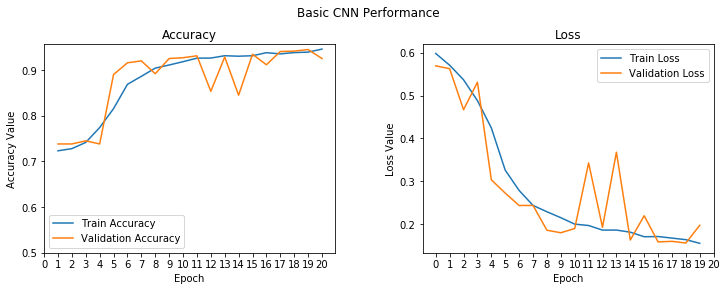

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,21))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 21, 1))
ax1.set_yticks(np.arange(.5, 1, .1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 21, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [29]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.1971566847973716
Test accuracy: 0.92491466


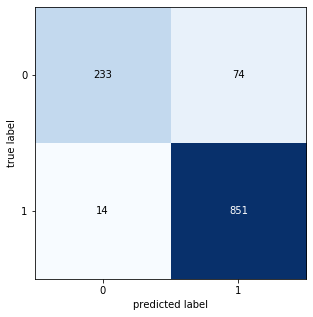

In [30]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)
CM = confusion_matrix(y_true, pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [31]:
# Precision Score
# precision = True Positive / (True Positive + False Positive)
print ("Precision Score: {}".format(CM[1][1] / (CM[1][1] + CM[0][1])))

# Recall Score
# recall = True Positive / (True Positive + False Negative)
print ("Recall Score: {}".format(CM[1][1] / (CM[1][1] + CM[1][0])))

Precision Score: 0.92
Recall Score: 0.9838150289017341


Summary:

- Validation Accuracy after 20 epochs: 92.5 %
- Precision Score: 92.0 %
- Recall Score: 98.4 %

## CNN Model with Image Augmentation

In [32]:
train_datagen = ImageDataGenerator(zoom_range=0.3, width_shift_range=0.2, 
                                   height_shift_range=0.2, shear_range=0.2, horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator()

In [34]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=30)
val_generator = val_datagen.flow(X_test, y_test, batch_size=20)
input_shape = (128, 128, 3)

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))


model.compile(optimizer='sgd', loss='categorical_crossentropy',
            metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 61, 61, 64)        9280      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 128)      

In [35]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=epochs,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1)

Epoch 1/20
100/100 [==============================] - ETA: 1:07 - loss: 0.6843 - accuracy: 0.76 - ETA: 58s - loss: 0.6843 - accuracy: 0.7000 - ETA: 56s - loss: 0.6827 - accuracy: 0.711 - ETA: 54s - loss: 0.6778 - accuracy: 0.741 - ETA: 52s - loss: 0.6754 - accuracy: 0.740 - ETA: 51s - loss: 0.6745 - accuracy: 0.727 - ETA: 50s - loss: 0.6715 - accuracy: 0.728 - ETA: 50s - loss: 0.6720 - accuracy: 0.716 - ETA: 49s - loss: 0.6749 - accuracy: 0.696 - ETA: 49s - loss: 0.6750 - accuracy: 0.690 - ETA: 48s - loss: 0.6749 - accuracy: 0.687 - ETA: 47s - loss: 0.6759 - accuracy: 0.677 - ETA: 47s - loss: 0.6739 - accuracy: 0.684 - ETA: 46s - loss: 0.6715 - accuracy: 0.690 - ETA: 46s - loss: 0.6683 - accuracy: 0.697 - ETA: 45s - loss: 0.6673 - accuracy: 0.695 - ETA: 45s - loss: 0.6646 - accuracy: 0.700 - ETA: 44s - loss: 0.6650 - accuracy: 0.694 - ETA: 43s - loss: 0.6627 - accuracy: 0.698 - ETA: 43s - loss: 0.6612 - accuracy: 0.700 - ETA: 42s - loss: 0.6588 - accuracy: 0.703 - ETA: 42s - loss: 0.65

100/100 [==============================] - ETA: 51s - loss: 0.5987 - accuracy: 0.733 - ETA: 50s - loss: 0.5100 - accuracy: 0.800 - ETA: 50s - loss: 0.5521 - accuracy: 0.766 - ETA: 49s - loss: 0.5879 - accuracy: 0.733 - ETA: 49s - loss: 0.6089 - accuracy: 0.713 - ETA: 48s - loss: 0.6169 - accuracy: 0.705 - ETA: 48s - loss: 0.6088 - accuracy: 0.714 - ETA: 47s - loss: 0.6091 - accuracy: 0.712 - ETA: 47s - loss: 0.6204 - accuracy: 0.700 - ETA: 46s - loss: 0.6317 - accuracy: 0.686 - ETA: 46s - loss: 0.6363 - accuracy: 0.681 - ETA: 45s - loss: 0.6307 - accuracy: 0.688 - ETA: 45s - loss: 0.6240 - accuracy: 0.697 - ETA: 44s - loss: 0.6121 - accuracy: 0.711 - ETA: 44s - loss: 0.6213 - accuracy: 0.704 - ETA: 43s - loss: 0.6185 - accuracy: 0.708 - ETA: 43s - loss: 0.6164 - accuracy: 0.709 - ETA: 42s - loss: 0.6161 - accuracy: 0.709 - ETA: 42s - loss: 0.6178 - accuracy: 0.707 - ETA: 41s - loss: 0.6152 - accuracy: 0.710 - ETA: 41s - loss: 0.6160 - accuracy: 0.707 - ETA: 40s - loss: 0.6189 - accurac

100/100 [==============================] - ETA: 51s - loss: 0.5613 - accuracy: 0.766 - ETA: 50s - loss: 0.5257 - accuracy: 0.800 - ETA: 50s - loss: 0.5232 - accuracy: 0.800 - ETA: 49s - loss: 0.5107 - accuracy: 0.808 - ETA: 49s - loss: 0.5177 - accuracy: 0.800 - ETA: 48s - loss: 0.5336 - accuracy: 0.783 - ETA: 48s - loss: 0.5303 - accuracy: 0.785 - ETA: 47s - loss: 0.5551 - accuracy: 0.762 - ETA: 47s - loss: 0.5668 - accuracy: 0.751 - ETA: 46s - loss: 0.5811 - accuracy: 0.736 - ETA: 46s - loss: 0.5803 - accuracy: 0.739 - ETA: 45s - loss: 0.5826 - accuracy: 0.736 - ETA: 45s - loss: 0.5821 - accuracy: 0.738 - ETA: 44s - loss: 0.5970 - accuracy: 0.721 - ETA: 44s - loss: 0.5934 - accuracy: 0.724 - ETA: 43s - loss: 0.5893 - accuracy: 0.729 - ETA: 43s - loss: 0.5895 - accuracy: 0.729 - ETA: 42s - loss: 0.5935 - accuracy: 0.724 - ETA: 42s - loss: 0.5957 - accuracy: 0.721 - ETA: 41s - loss: 0.5946 - accuracy: 0.723 - ETA: 41s - loss: 0.5956 - accuracy: 0.722 - ETA: 40s - loss: 0.5988 - accurac

100/100 [==============================] - ETA: 51s - loss: 0.4895 - accuracy: 0.800 - ETA: 50s - loss: 0.5767 - accuracy: 0.733 - ETA: 50s - loss: 0.5783 - accuracy: 0.733 - ETA: 49s - loss: 0.5686 - accuracy: 0.741 - ETA: 49s - loss: 0.5789 - accuracy: 0.733 - ETA: 48s - loss: 0.5783 - accuracy: 0.733 - ETA: 48s - loss: 0.5837 - accuracy: 0.728 - ETA: 47s - loss: 0.5712 - accuracy: 0.741 - ETA: 47s - loss: 0.5783 - accuracy: 0.733 - ETA: 46s - loss: 0.5820 - accuracy: 0.730 - ETA: 46s - loss: 0.5751 - accuracy: 0.736 - ETA: 45s - loss: 0.5720 - accuracy: 0.738 - ETA: 45s - loss: 0.5702 - accuracy: 0.741 - ETA: 44s - loss: 0.5697 - accuracy: 0.742 - ETA: 44s - loss: 0.5739 - accuracy: 0.740 - ETA: 43s - loss: 0.5719 - accuracy: 0.741 - ETA: 43s - loss: 0.5654 - accuracy: 0.747 - ETA: 42s - loss: 0.5620 - accuracy: 0.750 - ETA: 42s - loss: 0.5624 - accuracy: 0.749 - ETA: 41s - loss: 0.5661 - accuracy: 0.745 - ETA: 41s - loss: 0.5677 - accuracy: 0.742 - ETA: 40s - loss: 0.5617 - accurac

100/100 [==============================] - ETA: 51s - loss: 0.5430 - accuracy: 0.733 - ETA: 51s - loss: 0.5234 - accuracy: 0.766 - ETA: 50s - loss: 0.5565 - accuracy: 0.744 - ETA: 50s - loss: 0.5560 - accuracy: 0.741 - ETA: 49s - loss: 0.5579 - accuracy: 0.740 - ETA: 49s - loss: 0.5617 - accuracy: 0.738 - ETA: 48s - loss: 0.5770 - accuracy: 0.723 - ETA: 48s - loss: 0.5867 - accuracy: 0.712 - ETA: 47s - loss: 0.5850 - accuracy: 0.714 - ETA: 46s - loss: 0.5762 - accuracy: 0.726 - ETA: 46s - loss: 0.5598 - accuracy: 0.739 - ETA: 45s - loss: 0.5656 - accuracy: 0.733 - ETA: 45s - loss: 0.5753 - accuracy: 0.723 - ETA: 44s - loss: 0.5681 - accuracy: 0.733 - ETA: 44s - loss: 0.5640 - accuracy: 0.737 - ETA: 43s - loss: 0.5707 - accuracy: 0.733 - ETA: 43s - loss: 0.5678 - accuracy: 0.737 - ETA: 42s - loss: 0.5637 - accuracy: 0.740 - ETA: 42s - loss: 0.5666 - accuracy: 0.738 - ETA: 41s - loss: 0.5630 - accuracy: 0.741 - ETA: 41s - loss: 0.5629 - accuracy: 0.739 - ETA: 40s - loss: 0.5647 - accurac

100/100 [==============================] - ETA: 51s - loss: 0.5747 - accuracy: 0.800 - ETA: 51s - loss: 0.5229 - accuracy: 0.800 - ETA: 50s - loss: 0.5326 - accuracy: 0.777 - ETA: 50s - loss: 0.5125 - accuracy: 0.791 - ETA: 49s - loss: 0.5384 - accuracy: 0.766 - ETA: 49s - loss: 0.5654 - accuracy: 0.727 - ETA: 48s - loss: 0.5732 - accuracy: 0.738 - ETA: 47s - loss: 0.5762 - accuracy: 0.733 - ETA: 47s - loss: 0.5704 - accuracy: 0.737 - ETA: 46s - loss: 0.5685 - accuracy: 0.736 - ETA: 46s - loss: 0.5727 - accuracy: 0.730 - ETA: 45s - loss: 0.5656 - accuracy: 0.738 - ETA: 45s - loss: 0.5660 - accuracy: 0.738 - ETA: 44s - loss: 0.5611 - accuracy: 0.742 - ETA: 44s - loss: 0.5535 - accuracy: 0.746 - ETA: 43s - loss: 0.5482 - accuracy: 0.750 - ETA: 43s - loss: 0.5502 - accuracy: 0.747 - ETA: 42s - loss: 0.5483 - accuracy: 0.750 - ETA: 42s - loss: 0.5456 - accuracy: 0.750 - ETA: 41s - loss: 0.5483 - accuracy: 0.748 - ETA: 41s - loss: 0.5498 - accuracy: 0.744 - ETA: 40s - loss: 0.5479 - accurac

100/100 [==============================] - ETA: 51s - loss: 0.6175 - accuracy: 0.766 - ETA: 51s - loss: 0.5696 - accuracy: 0.733 - ETA: 50s - loss: 0.5573 - accuracy: 0.733 - ETA: 49s - loss: 0.5543 - accuracy: 0.725 - ETA: 49s - loss: 0.5514 - accuracy: 0.733 - ETA: 48s - loss: 0.5468 - accuracy: 0.733 - ETA: 48s - loss: 0.5438 - accuracy: 0.733 - ETA: 47s - loss: 0.5311 - accuracy: 0.737 - ETA: 47s - loss: 0.5433 - accuracy: 0.725 - ETA: 46s - loss: 0.5438 - accuracy: 0.720 - ETA: 46s - loss: 0.5312 - accuracy: 0.730 - ETA: 45s - loss: 0.5350 - accuracy: 0.730 - ETA: 45s - loss: 0.5304 - accuracy: 0.730 - ETA: 44s - loss: 0.5288 - accuracy: 0.728 - ETA: 44s - loss: 0.5271 - accuracy: 0.731 - ETA: 43s - loss: 0.5215 - accuracy: 0.733 - ETA: 43s - loss: 0.5174 - accuracy: 0.735 - ETA: 42s - loss: 0.5172 - accuracy: 0.733 - ETA: 42s - loss: 0.5162 - accuracy: 0.735 - ETA: 41s - loss: 0.5219 - accuracy: 0.733 - ETA: 41s - loss: 0.5207 - accuracy: 0.733 - ETA: 40s - loss: 0.5210 - accurac

100/100 [==============================] - ETA: 51s - loss: 0.4023 - accuracy: 0.833 - ETA: 50s - loss: 0.4640 - accuracy: 0.800 - ETA: 50s - loss: 0.4420 - accuracy: 0.811 - ETA: 49s - loss: 0.4597 - accuracy: 0.791 - ETA: 49s - loss: 0.4604 - accuracy: 0.773 - ETA: 48s - loss: 0.4876 - accuracy: 0.750 - ETA: 48s - loss: 0.5335 - accuracy: 0.723 - ETA: 47s - loss: 0.5293 - accuracy: 0.737 - ETA: 47s - loss: 0.5222 - accuracy: 0.744 - ETA: 46s - loss: 0.5207 - accuracy: 0.740 - ETA: 46s - loss: 0.5202 - accuracy: 0.736 - ETA: 45s - loss: 0.5212 - accuracy: 0.730 - ETA: 45s - loss: 0.5235 - accuracy: 0.728 - ETA: 44s - loss: 0.5267 - accuracy: 0.726 - ETA: 44s - loss: 0.5231 - accuracy: 0.733 - ETA: 43s - loss: 0.5202 - accuracy: 0.737 - ETA: 43s - loss: 0.5154 - accuracy: 0.739 - ETA: 42s - loss: 0.5124 - accuracy: 0.738 - ETA: 42s - loss: 0.5115 - accuracy: 0.740 - ETA: 41s - loss: 0.5107 - accuracy: 0.745 - ETA: 41s - loss: 0.5168 - accuracy: 0.739 - ETA: 40s - loss: 0.5198 - accurac

100/100 [==============================] - ETA: 51s - loss: 0.4649 - accuracy: 0.833 - ETA: 50s - loss: 0.4326 - accuracy: 0.833 - ETA: 50s - loss: 0.4105 - accuracy: 0.833 - ETA: 49s - loss: 0.4205 - accuracy: 0.808 - ETA: 49s - loss: 0.4303 - accuracy: 0.813 - ETA: 48s - loss: 0.4400 - accuracy: 0.805 - ETA: 48s - loss: 0.4449 - accuracy: 0.795 - ETA: 47s - loss: 0.4465 - accuracy: 0.800 - ETA: 47s - loss: 0.4468 - accuracy: 0.788 - ETA: 46s - loss: 0.4513 - accuracy: 0.790 - ETA: 46s - loss: 0.4480 - accuracy: 0.787 - ETA: 45s - loss: 0.4415 - accuracy: 0.797 - ETA: 45s - loss: 0.4349 - accuracy: 0.800 - ETA: 44s - loss: 0.4292 - accuracy: 0.804 - ETA: 44s - loss: 0.4301 - accuracy: 0.802 - ETA: 43s - loss: 0.4328 - accuracy: 0.797 - ETA: 43s - loss: 0.4334 - accuracy: 0.802 - ETA: 42s - loss: 0.4329 - accuracy: 0.798 - ETA: 42s - loss: 0.4340 - accuracy: 0.796 - ETA: 41s - loss: 0.4774 - accuracy: 0.783 - ETA: 41s - loss: 0.4813 - accuracy: 0.777 - ETA: 40s - loss: 0.4840 - accurac

100/100 [==============================] - ETA: 51s - loss: 0.7099 - accuracy: 0.666 - ETA: 50s - loss: 0.5545 - accuracy: 0.766 - ETA: 50s - loss: 0.4754 - accuracy: 0.788 - ETA: 49s - loss: 0.4561 - accuracy: 0.800 - ETA: 49s - loss: 0.4282 - accuracy: 0.813 - ETA: 48s - loss: 0.4109 - accuracy: 0.822 - ETA: 48s - loss: 0.4061 - accuracy: 0.823 - ETA: 47s - loss: 0.4093 - accuracy: 0.825 - ETA: 47s - loss: 0.4296 - accuracy: 0.803 - ETA: 46s - loss: 0.4197 - accuracy: 0.810 - ETA: 46s - loss: 0.4242 - accuracy: 0.809 - ETA: 45s - loss: 0.4515 - accuracy: 0.791 - ETA: 45s - loss: 0.4478 - accuracy: 0.794 - ETA: 44s - loss: 0.4396 - accuracy: 0.800 - ETA: 44s - loss: 0.4349 - accuracy: 0.806 - ETA: 43s - loss: 0.4349 - accuracy: 0.804 - ETA: 43s - loss: 0.4414 - accuracy: 0.798 - ETA: 42s - loss: 0.4410 - accuracy: 0.794 - ETA: 42s - loss: 0.4438 - accuracy: 0.789 - ETA: 41s - loss: 0.4398 - accuracy: 0.793 - ETA: 41s - loss: 0.4327 - accuracy: 0.796 - ETA: 40s - loss: 0.4272 - accurac

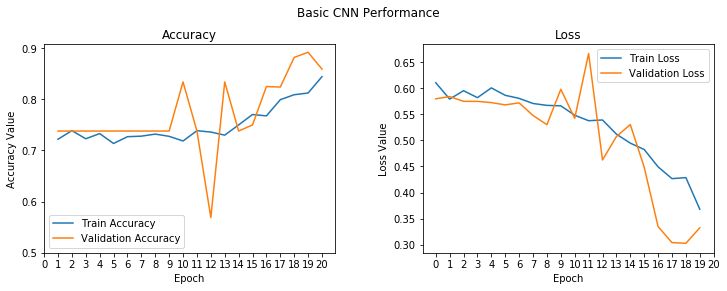

In [37]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,21))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 21, 1))
ax1.set_yticks(np.arange(.5, 1, .1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 21, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [38]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.33441202937539527
Test accuracy: 0.8609215


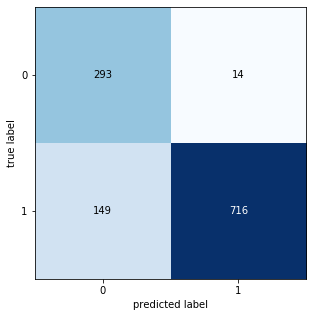

In [39]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)
CM = confusion_matrix(y_true, pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [40]:
# Precision Score
# precision = True Positive / (True Positive + False Positive)
print ("Precision Score: {}".format(CM[1][1] / (CM[1][1] + CM[0][1])))

# Recall Score
# recall = True Positive / (True Positive + False Negative)
print ("Recall Score: {}".format(CM[1][1] / (CM[1][1] + CM[1][0])))

Precision Score: 0.9808219178082191
Recall Score: 0.8277456647398844


Summary:

- Validation Accuracy after 20 epochs: 86.1%
- Precision Score: 98.1 %
- Recall Score: 82.8 %

# Transfer Learning

## Pre-trained CNN using VGG-16

In [48]:
base_model=VGG16(include_top=False, weights='imagenet',input_shape=(128,128,3), pooling='avg')
base_model.trainable=False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [49]:
model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))


model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy',
            metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                

In [50]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [51]:
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = 10, validation_data = (X_test,y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/10
73/73 [==============================] - ETA: 29:14 - loss: 0.7281 - accuracy: 0.515 - ETA: 29:10 - loss: 0.7198 - accuracy: 0.492 - ETA: 28:28 - loss: 0.7000 - accuracy: 0.536 - ETA: 27:55 - loss: 0.6829 - accuracy: 0.570 - ETA: 27:35 - loss: 0.6807 - accuracy: 0.590 - ETA: 27:12 - loss: 0.6583 - accuracy: 0.627 - ETA: 26:53 - loss: 0.6323 - accuracy: 0.656 - ETA: 26:33 - loss: 0.6343 - accuracy: 0.658 - ETA: 26:03 - loss: 0.6458 - accuracy: 0.663 - ETA: 25:33 - loss: 0.6164 - accuracy: 0.685 - ETA: 25:04 - loss: 0.6172 - accuracy: 0.691 - ETA: 24:35 - loss: 0.6022 - accuracy: 0.704 - ETA: 24:08 - loss: 0.6002 - accuracy: 0.707 - ETA: 23:41 - loss: 0.6027 - accuracy: 0.710 - ETA: 23:15 - loss: 0.6133 - accuracy: 0.708 - ETA: 22:49 - loss: 0.6047 - accuracy: 0.714 - ETA: 22:23 - loss: 0.6091 - accuracy: 0.712 - ETA: 21:58 - loss: 0.6117 - accuracy: 0.711 - ETA: 21:33 - loss: 0.6076 - accuracy: 0.715 - ETA: 21:10 - loss: 0.6057 - accuracy: 0.717 - ETA: 20:45 - loss: 0.6093 - 

73/73 [==============================] - ETA: 5:34 - loss: 0.2889 - accuracy: 0.91 - ETA: 16:42 - loss: 0.2544 - accuracy: 0.907 - ETA: 20:08 - loss: 0.2353 - accuracy: 0.928 - ETA: 21:40 - loss: 0.2387 - accuracy: 0.916 - ETA: 22:24 - loss: 0.2647 - accuracy: 0.895 - ETA: 22:46 - loss: 0.2605 - accuracy: 0.900 - ETA: 22:56 - loss: 0.2565 - accuracy: 0.899 - ETA: 22:57 - loss: 0.2632 - accuracy: 0.895 - ETA: 22:53 - loss: 0.2630 - accuracy: 0.896 - ETA: 22:45 - loss: 0.2645 - accuracy: 0.891 - ETA: 22:34 - loss: 0.2662 - accuracy: 0.891 - ETA: 22:21 - loss: 0.2616 - accuracy: 0.892 - ETA: 22:07 - loss: 0.2563 - accuracy: 0.894 - ETA: 21:51 - loss: 0.2491 - accuracy: 0.899 - ETA: 21:33 - loss: 0.2530 - accuracy: 0.900 - ETA: 21:15 - loss: 0.2546 - accuracy: 0.899 - ETA: 20:57 - loss: 0.2526 - accuracy: 0.898 - ETA: 20:38 - loss: 0.2552 - accuracy: 0.894 - ETA: 20:18 - loss: 0.2610 - accuracy: 0.890 - ETA: 19:58 - loss: 0.2606 - accuracy: 0.890 - ETA: 19:38 - loss: 0.2600 - accuracy: 0.8

73/73 [==============================] - ETA: 28:05 - loss: 0.1628 - accuracy: 0.953 - ETA: 27:38 - loss: 0.1997 - accuracy: 0.914 - ETA: 27:15 - loss: 0.1845 - accuracy: 0.927 - ETA: 26:52 - loss: 0.2345 - accuracy: 0.894 - ETA: 26:30 - loss: 0.2101 - accuracy: 0.909 - ETA: 26:08 - loss: 0.2130 - accuracy: 0.908 - ETA: 25:45 - loss: 0.2188 - accuracy: 0.904 - ETA: 25:22 - loss: 0.2223 - accuracy: 0.896 - ETA: 24:58 - loss: 0.2170 - accuracy: 0.899 - ETA: 24:34 - loss: 0.2163 - accuracy: 0.898 - ETA: 24:10 - loss: 0.2165 - accuracy: 0.899 - ETA: 23:47 - loss: 0.2235 - accuracy: 0.895 - ETA: 23:23 - loss: 0.2163 - accuracy: 0.900 - ETA: 22:59 - loss: 0.2196 - accuracy: 0.901 - ETA: 22:36 - loss: 0.2276 - accuracy: 0.901 - ETA: 22:12 - loss: 0.2265 - accuracy: 0.900 - ETA: 21:49 - loss: 0.2287 - accuracy: 0.898 - ETA: 21:25 - loss: 0.2283 - accuracy: 0.899 - ETA: 21:02 - loss: 0.2269 - accuracy: 0.898 - ETA: 20:39 - loss: 0.2285 - accuracy: 0.899 - ETA: 20:15 - loss: 0.2265 - accuracy: 0

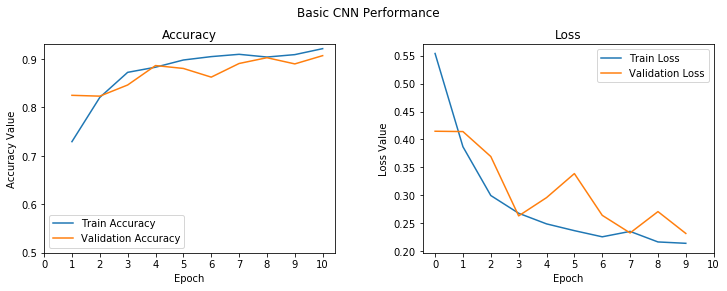

In [52]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,11))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 11, 1))
ax1.set_yticks(np.arange(.5, 1, .1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 11, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [53]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.22988300244149087
Test accuracy: 0.9069966


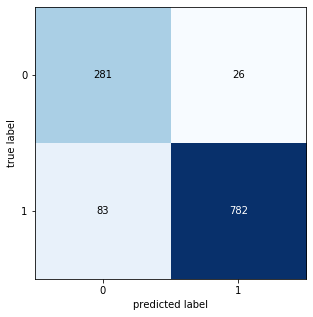

In [54]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)
CM = confusion_matrix(y_true, pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [55]:
# Precision Score
# precision = True Positive / (True Positive + False Positive)
print ("Precision Score: {}".format(CM[1][1] / (CM[1][1] + CM[0][1])))

# Recall Score
# recall = True Positive / (True Positive + False Negative)
print ("Recall Score: {}".format(CM[1][1] / (CM[1][1] + CM[1][0])))

Precision Score: 0.9678217821782178
Recall Score: 0.9040462427745665


## Pre-trained CNN using MobileNet

In [5]:
os.chdir('D:/Thinkful Data Science/Data Sets/Chest Xrays/From Kaggle/17810_23812_bundle_archive/chest_xray/chest_xray')
print(os.listdir())

['test', 'train', 'val']


In [16]:
IMAGE_SIZE =[128,128]
Train ="../train/"
Test ="../test/"
Val = "../val/"

print(os.listdir(Val))

['NORMAL', 'PNEUMONIA']


In [23]:
mn_model = MobileNetV2(input_shape=(128,128,3),include_top=False, weights='imagenet')

mn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

mn_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

block_4_expand_relu (ReLU)      (None, 16, 16, 192)  0           block_4_expand_BN[0][0]          
__________________________________________________________________________________________________
block_4_depthwise (DepthwiseCon (None, 16, 16, 192)  1728        block_4_expand_relu[0][0]        
__________________________________________________________________________________________________
block_4_depthwise_BN (BatchNorm (None, 16, 16, 192)  768         block_4_depthwise[0][0]          
__________________________________________________________________________________________________
block_4_depthwise_relu (ReLU)   (None, 16, 16, 192)  0           block_4_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_4_project (Conv2D)        (None, 16, 16, 32)   6144        block_4_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_4_pr

__________________________________________________________________________________________________
block_8_project (Conv2D)        (None, 8, 8, 64)     24576       block_8_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_8_project_BN (BatchNormal (None, 8, 8, 64)     256         block_8_project[0][0]            
__________________________________________________________________________________________________
block_8_add (Add)               (None, 8, 8, 64)     0           block_7_add[0][0]                
                                                                 block_8_project_BN[0][0]         
__________________________________________________________________________________________________
block_9_expand (Conv2D)         (None, 8, 8, 384)    24576       block_8_add[0][0]                
__________________________________________________________________________________________________
block_9_ex

__________________________________________________________________________________________________
block_13_expand_BN (BatchNormal (None, 8, 8, 576)    2304        block_13_expand[0][0]            
__________________________________________________________________________________________________
block_13_expand_relu (ReLU)     (None, 8, 8, 576)    0           block_13_expand_BN[0][0]         
__________________________________________________________________________________________________
block_13_pad (ZeroPadding2D)    (None, 9, 9, 576)    0           block_13_expand_relu[0][0]       
__________________________________________________________________________________________________
block_13_depthwise (DepthwiseCo (None, 4, 4, 576)    5184        block_13_pad[0][0]               
__________________________________________________________________________________________________
block_13_depthwise_BN (BatchNor (None, 4, 4, 576)    2304        block_13_depthwise[0][0]         
__________

In [24]:
for layer in mn_model.layers:
    layer.trainable = False

mn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])    
    
mn_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

block_4_expand_relu (ReLU)      (None, 16, 16, 192)  0           block_4_expand_BN[0][0]          
__________________________________________________________________________________________________
block_4_depthwise (DepthwiseCon (None, 16, 16, 192)  1728        block_4_expand_relu[0][0]        
__________________________________________________________________________________________________
block_4_depthwise_BN (BatchNorm (None, 16, 16, 192)  768         block_4_depthwise[0][0]          
__________________________________________________________________________________________________
block_4_depthwise_relu (ReLU)   (None, 16, 16, 192)  0           block_4_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_4_project (Conv2D)        (None, 16, 16, 32)   6144        block_4_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_4_pr

__________________________________________________________________________________________________
block_8_project (Conv2D)        (None, 8, 8, 64)     24576       block_8_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_8_project_BN (BatchNormal (None, 8, 8, 64)     256         block_8_project[0][0]            
__________________________________________________________________________________________________
block_8_add (Add)               (None, 8, 8, 64)     0           block_7_add[0][0]                
                                                                 block_8_project_BN[0][0]         
__________________________________________________________________________________________________
block_9_expand (Conv2D)         (None, 8, 8, 384)    24576       block_8_add[0][0]                
__________________________________________________________________________________________________
block_9_ex

__________________________________________________________________________________________________
block_13_expand_BN (BatchNormal (None, 8, 8, 576)    2304        block_13_expand[0][0]            
__________________________________________________________________________________________________
block_13_expand_relu (ReLU)     (None, 8, 8, 576)    0           block_13_expand_BN[0][0]         
__________________________________________________________________________________________________
block_13_pad (ZeroPadding2D)    (None, 9, 9, 576)    0           block_13_expand_relu[0][0]       
__________________________________________________________________________________________________
block_13_depthwise (DepthwiseCo (None, 4, 4, 576)    5184        block_13_pad[0][0]               
__________________________________________________________________________________________________
block_13_depthwise_BN (BatchNor (None, 4, 4, 576)    2304        block_13_depthwise[0][0]         
__________

In [25]:
train_datagen = ImageDataGenerator( 
    rescale=1. / 255, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True)
  
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory( 
    Train, 
    target_size=(128, 128), 
    batch_size=64, 
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory( 
    Test, 
    target_size=(128, 128), 
    batch_size=32, 
    class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [27]:
mobilenet_model=Sequential()
mobilenet_model.add(mn_model)
mobilenet_model.add(Flatten())
mobilenet_model.add(Dense(256, activation='relu'))
mobilenet_model.add(Dropout(0.3))
mobilenet_model.add(Dense(256, activation='relu'))
mobilenet_model.add(Dropout(0.3))
mobilenet_model.add(Dense(2, activation='softmax'))


mobilenet_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy',
            metrics=['accuracy'])

mobilenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 20480)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               5243136   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

In [28]:
history = mobilenet_model.fit_generator(train_generator,
                       validation_data = validation_generator,
                       epochs =10,
                       steps_per_epoch = 100,
                       validation_steps = 25)

Epoch 1/10
100/100 [==============================] - ETA: 13:15 - loss: 1.8655 - accuracy: 0.265 - ETA: 11:37 - loss: 1.3135 - accuracy: 0.476 - ETA: 10:56 - loss: 1.3307 - accuracy: 0.536 - ETA: 10:41 - loss: 1.1859 - accuracy: 0.597 - ETA: 10:34 - loss: 1.1227 - accuracy: 0.618 - ETA: 10:25 - loss: 1.0424 - accuracy: 0.635 - ETA: 10:17 - loss: 0.9605 - accuracy: 0.660 - ETA: 10:05 - loss: 0.8980 - accuracy: 0.666 - ETA: 10:02 - loss: 0.8389 - accuracy: 0.685 - ETA: 9:56 - loss: 0.8028 - accuracy: 0.696 - ETA: 9:50 - loss: 0.7672 - accuracy: 0.71 - ETA: 9:41 - loss: 0.7329 - accuracy: 0.72 - ETA: 9:27 - loss: 0.7112 - accuracy: 0.72 - ETA: 9:16 - loss: 0.6842 - accuracy: 0.73 - ETA: 9:05 - loss: 0.6527 - accuracy: 0.74 - ETA: 8:54 - loss: 0.6351 - accuracy: 0.74 - ETA: 8:46 - loss: 0.6068 - accuracy: 0.75 - ETA: 8:37 - loss: 0.5886 - accuracy: 0.76 - ETA: 8:28 - loss: 0.5790 - accuracy: 0.77 - ETA: 8:18 - loss: 0.5626 - accuracy: 0.77 - ETA: 8:11 - loss: 0.5500 - accuracy: 0.77 - ETA

100/100 [==============================] - ETA: 9:22 - loss: 0.2004 - accuracy: 0.92 - ETA: 9:14 - loss: 0.1857 - accuracy: 0.93 - ETA: 9:10 - loss: 0.1928 - accuracy: 0.94 - ETA: 9:04 - loss: 0.1732 - accuracy: 0.94 - ETA: 9:02 - loss: 0.1821 - accuracy: 0.93 - ETA: 8:55 - loss: 0.1900 - accuracy: 0.92 - ETA: 8:53 - loss: 0.1815 - accuracy: 0.92 - ETA: 8:44 - loss: 0.1815 - accuracy: 0.92 - ETA: 8:35 - loss: 0.1767 - accuracy: 0.92 - ETA: 8:26 - loss: 0.1732 - accuracy: 0.92 - ETA: 8:19 - loss: 0.1852 - accuracy: 0.92 - ETA: 8:12 - loss: 0.1751 - accuracy: 0.92 - ETA: 8:05 - loss: 0.1766 - accuracy: 0.92 - ETA: 7:58 - loss: 0.1767 - accuracy: 0.92 - ETA: 7:52 - loss: 0.1732 - accuracy: 0.92 - ETA: 7:45 - loss: 0.1694 - accuracy: 0.92 - ETA: 7:39 - loss: 0.1680 - accuracy: 0.92 - ETA: 7:33 - loss: 0.1724 - accuracy: 0.92 - ETA: 7:27 - loss: 0.1750 - accuracy: 0.92 - ETA: 7:21 - loss: 0.1788 - accuracy: 0.92 - ETA: 7:06 - loss: 0.1876 - accuracy: 0.92 - ETA: 7:00 - loss: 0.1846 - accura

100/100 [==============================] - ETA: 8:52 - loss: 0.2695 - accuracy: 0.93 - ETA: 8:49 - loss: 0.1850 - accuracy: 0.93 - ETA: 8:44 - loss: 0.1549 - accuracy: 0.95 - ETA: 8:37 - loss: 0.1551 - accuracy: 0.94 - ETA: 8:35 - loss: 0.1504 - accuracy: 0.94 - ETA: 8:29 - loss: 0.1412 - accuracy: 0.95 - ETA: 8:23 - loss: 0.1539 - accuracy: 0.94 - ETA: 8:18 - loss: 0.1624 - accuracy: 0.94 - ETA: 8:13 - loss: 0.1628 - accuracy: 0.94 - ETA: 8:07 - loss: 0.1811 - accuracy: 0.93 - ETA: 8:03 - loss: 0.1802 - accuracy: 0.93 - ETA: 7:58 - loss: 0.1768 - accuracy: 0.93 - ETA: 7:52 - loss: 0.1744 - accuracy: 0.93 - ETA: 7:46 - loss: 0.1686 - accuracy: 0.93 - ETA: 7:41 - loss: 0.1639 - accuracy: 0.93 - ETA: 7:36 - loss: 0.1621 - accuracy: 0.93 - ETA: 7:30 - loss: 0.1597 - accuracy: 0.93 - ETA: 7:25 - loss: 0.1571 - accuracy: 0.93 - ETA: 7:19 - loss: 0.1550 - accuracy: 0.93 - ETA: 7:13 - loss: 0.1540 - accuracy: 0.93 - ETA: 7:08 - loss: 0.1580 - accuracy: 0.93 - ETA: 7:02 - loss: 0.1567 - accura

100/100 [==============================] - ETA: 9:01 - loss: 0.1292 - accuracy: 0.96 - ETA: 8:53 - loss: 0.1828 - accuracy: 0.95 - ETA: 8:46 - loss: 0.1675 - accuracy: 0.93 - ETA: 8:40 - loss: 0.1717 - accuracy: 0.93 - ETA: 8:34 - loss: 0.1797 - accuracy: 0.93 - ETA: 8:29 - loss: 0.1783 - accuracy: 0.93 - ETA: 8:23 - loss: 0.1720 - accuracy: 0.93 - ETA: 8:18 - loss: 0.1944 - accuracy: 0.92 - ETA: 8:12 - loss: 0.1926 - accuracy: 0.93 - ETA: 8:06 - loss: 0.1822 - accuracy: 0.93 - ETA: 8:01 - loss: 0.1731 - accuracy: 0.93 - ETA: 7:55 - loss: 0.1711 - accuracy: 0.94 - ETA: 7:51 - loss: 0.1855 - accuracy: 0.93 - ETA: 7:45 - loss: 0.1869 - accuracy: 0.93 - ETA: 7:40 - loss: 0.1768 - accuracy: 0.93 - ETA: 7:34 - loss: 0.1712 - accuracy: 0.94 - ETA: 7:29 - loss: 0.1686 - accuracy: 0.94 - ETA: 7:23 - loss: 0.1711 - accuracy: 0.93 - ETA: 7:16 - loss: 0.1712 - accuracy: 0.93 - ETA: 7:10 - loss: 0.1669 - accuracy: 0.93 - ETA: 7:03 - loss: 0.1680 - accuracy: 0.93 - ETA: 6:57 - loss: 0.1722 - accura

100/100 [==============================] - ETA: 8:29 - loss: 0.1021 - accuracy: 0.96 - ETA: 8:20 - loss: 0.1440 - accuracy: 0.95 - ETA: 8:15 - loss: 0.1353 - accuracy: 0.95 - ETA: 8:09 - loss: 0.1353 - accuracy: 0.94 - ETA: 8:04 - loss: 0.1409 - accuracy: 0.94 - ETA: 7:59 - loss: 0.1449 - accuracy: 0.94 - ETA: 7:55 - loss: 0.1613 - accuracy: 0.94 - ETA: 7:49 - loss: 0.1529 - accuracy: 0.94 - ETA: 7:44 - loss: 0.1646 - accuracy: 0.94 - ETA: 7:46 - loss: 0.1567 - accuracy: 0.94 - ETA: 7:48 - loss: 0.1565 - accuracy: 0.93 - ETA: 7:47 - loss: 0.1658 - accuracy: 0.93 - ETA: 7:43 - loss: 0.1664 - accuracy: 0.93 - ETA: 7:38 - loss: 0.1723 - accuracy: 0.93 - ETA: 7:32 - loss: 0.1687 - accuracy: 0.93 - ETA: 7:27 - loss: 0.1732 - accuracy: 0.93 - ETA: 7:22 - loss: 0.1673 - accuracy: 0.93 - ETA: 7:17 - loss: 0.1646 - accuracy: 0.93 - ETA: 7:12 - loss: 0.1646 - accuracy: 0.93 - ETA: 7:07 - loss: 0.1671 - accuracy: 0.93 - ETA: 7:02 - loss: 0.1681 - accuracy: 0.93 - ETA: 6:57 - loss: 0.1656 - accura

100/100 [==============================] - ETA: 8:56 - loss: 0.1945 - accuracy: 0.90 - ETA: 8:49 - loss: 0.2453 - accuracy: 0.92 - ETA: 8:42 - loss: 0.2167 - accuracy: 0.93 - ETA: 8:37 - loss: 0.1950 - accuracy: 0.93 - ETA: 8:31 - loss: 0.1962 - accuracy: 0.93 - ETA: 8:26 - loss: 0.2021 - accuracy: 0.92 - ETA: 8:21 - loss: 0.1869 - accuracy: 0.92 - ETA: 8:16 - loss: 0.1757 - accuracy: 0.93 - ETA: 8:11 - loss: 0.1681 - accuracy: 0.93 - ETA: 8:05 - loss: 0.1585 - accuracy: 0.93 - ETA: 8:00 - loss: 0.1526 - accuracy: 0.94 - ETA: 7:55 - loss: 0.1476 - accuracy: 0.94 - ETA: 7:49 - loss: 0.1500 - accuracy: 0.93 - ETA: 7:44 - loss: 0.1443 - accuracy: 0.94 - ETA: 7:38 - loss: 0.1443 - accuracy: 0.94 - ETA: 7:32 - loss: 0.1473 - accuracy: 0.93 - ETA: 7:27 - loss: 0.1535 - accuracy: 0.93 - ETA: 7:22 - loss: 0.1475 - accuracy: 0.94 - ETA: 7:16 - loss: 0.1451 - accuracy: 0.94 - ETA: 7:11 - loss: 0.1420 - accuracy: 0.94 - ETA: 7:05 - loss: 0.1411 - accuracy: 0.94 - ETA: 7:00 - loss: 0.1362 - accura

100/100 [==============================] - ETA: 9:06 - loss: 0.2400 - accuracy: 0.92 - ETA: 8:55 - loss: 0.1529 - accuracy: 0.94 - ETA: 8:43 - loss: 0.1304 - accuracy: 0.95 - ETA: 8:38 - loss: 0.1190 - accuracy: 0.95 - ETA: 8:34 - loss: 0.1224 - accuracy: 0.95 - ETA: 8:29 - loss: 0.1196 - accuracy: 0.95 - ETA: 8:23 - loss: 0.1192 - accuracy: 0.95 - ETA: 8:17 - loss: 0.1249 - accuracy: 0.95 - ETA: 8:12 - loss: 0.1224 - accuracy: 0.94 - ETA: 8:07 - loss: 0.1177 - accuracy: 0.95 - ETA: 8:02 - loss: 0.1177 - accuracy: 0.95 - ETA: 7:56 - loss: 0.1129 - accuracy: 0.95 - ETA: 7:51 - loss: 0.1140 - accuracy: 0.95 - ETA: 7:30 - loss: 0.1083 - accuracy: 0.95 - ETA: 7:26 - loss: 0.1107 - accuracy: 0.95 - ETA: 7:22 - loss: 0.1192 - accuracy: 0.95 - ETA: 7:18 - loss: 0.1202 - accuracy: 0.95 - ETA: 7:13 - loss: 0.1157 - accuracy: 0.95 - ETA: 7:08 - loss: 0.1198 - accuracy: 0.95 - ETA: 7:04 - loss: 0.1161 - accuracy: 0.95 - ETA: 6:59 - loss: 0.1148 - accuracy: 0.95 - ETA: 6:54 - loss: 0.1130 - accura

100/100 [==============================] - ETA: 8:36 - loss: 0.2313 - accuracy: 0.90 - ETA: 8:48 - loss: 0.1915 - accuracy: 0.91 - ETA: 8:43 - loss: 0.1621 - accuracy: 0.92 - ETA: 8:50 - loss: 0.1700 - accuracy: 0.92 - ETA: 8:47 - loss: 0.1770 - accuracy: 0.92 - ETA: 8:41 - loss: 0.1629 - accuracy: 0.93 - ETA: 8:34 - loss: 0.1491 - accuracy: 0.94 - ETA: 8:27 - loss: 0.1442 - accuracy: 0.94 - ETA: 8:21 - loss: 0.1317 - accuracy: 0.94 - ETA: 8:14 - loss: 0.1254 - accuracy: 0.95 - ETA: 8:08 - loss: 0.1229 - accuracy: 0.95 - ETA: 7:43 - loss: 0.1215 - accuracy: 0.95 - ETA: 7:39 - loss: 0.1235 - accuracy: 0.95 - ETA: 7:35 - loss: 0.1200 - accuracy: 0.95 - ETA: 7:30 - loss: 0.1170 - accuracy: 0.95 - ETA: 7:26 - loss: 0.1202 - accuracy: 0.95 - ETA: 7:24 - loss: 0.1266 - accuracy: 0.95 - ETA: 7:19 - loss: 0.1260 - accuracy: 0.95 - ETA: 7:14 - loss: 0.1291 - accuracy: 0.95 - ETA: 7:08 - loss: 0.1283 - accuracy: 0.95 - ETA: 7:03 - loss: 0.1271 - accuracy: 0.95 - ETA: 6:58 - loss: 0.1285 - accura

100/100 [==============================] - ETA: 8:56 - loss: 0.3502 - accuracy: 0.87 - ETA: 8:48 - loss: 0.2368 - accuracy: 0.91 - ETA: 8:44 - loss: 0.2089 - accuracy: 0.90 - ETA: 8:40 - loss: 0.1724 - accuracy: 0.92 - ETA: 8:36 - loss: 0.1459 - accuracy: 0.93 - ETA: 8:31 - loss: 0.1917 - accuracy: 0.92 - ETA: 8:25 - loss: 0.1761 - accuracy: 0.93 - ETA: 8:20 - loss: 0.1910 - accuracy: 0.92 - ETA: 8:14 - loss: 0.1807 - accuracy: 0.93 - ETA: 8:06 - loss: 0.1698 - accuracy: 0.93 - ETA: 7:59 - loss: 0.1688 - accuracy: 0.93 - ETA: 7:51 - loss: 0.1682 - accuracy: 0.93 - ETA: 7:44 - loss: 0.1634 - accuracy: 0.93 - ETA: 7:38 - loss: 0.1557 - accuracy: 0.94 - ETA: 7:31 - loss: 0.1505 - accuracy: 0.94 - ETA: 7:25 - loss: 0.1449 - accuracy: 0.94 - ETA: 7:18 - loss: 0.1401 - accuracy: 0.94 - ETA: 7:13 - loss: 0.1350 - accuracy: 0.94 - ETA: 7:07 - loss: 0.1316 - accuracy: 0.94 - ETA: 7:04 - loss: 0.1351 - accuracy: 0.94 - ETA: 7:02 - loss: 0.1358 - accuracy: 0.94 - ETA: 6:59 - loss: 0.1371 - accura

100/100 [==============================] - ETA: 8:41 - loss: 0.0959 - accuracy: 0.95 - ETA: 9:13 - loss: 0.0988 - accuracy: 0.95 - ETA: 9:20 - loss: 0.0951 - accuracy: 0.94 - ETA: 9:20 - loss: 0.0937 - accuracy: 0.95 - ETA: 9:06 - loss: 0.1327 - accuracy: 0.95 - ETA: 8:55 - loss: 0.1263 - accuracy: 0.95 - ETA: 8:46 - loss: 0.1243 - accuracy: 0.95 - ETA: 8:38 - loss: 0.1271 - accuracy: 0.95 - ETA: 8:31 - loss: 0.1305 - accuracy: 0.94 - ETA: 8:23 - loss: 0.1306 - accuracy: 0.95 - ETA: 8:16 - loss: 0.1373 - accuracy: 0.94 - ETA: 8:10 - loss: 0.1417 - accuracy: 0.94 - ETA: 8:04 - loss: 0.1370 - accuracy: 0.94 - ETA: 7:57 - loss: 0.1326 - accuracy: 0.95 - ETA: 7:51 - loss: 0.1314 - accuracy: 0.95 - ETA: 7:45 - loss: 0.1331 - accuracy: 0.95 - ETA: 7:39 - loss: 0.1304 - accuracy: 0.95 - ETA: 7:33 - loss: 0.1273 - accuracy: 0.95 - ETA: 7:27 - loss: 0.1252 - accuracy: 0.95 - ETA: 7:21 - loss: 0.1237 - accuracy: 0.95 - ETA: 7:15 - loss: 0.1233 - accuracy: 0.95 - ETA: 7:10 - loss: 0.1224 - accura

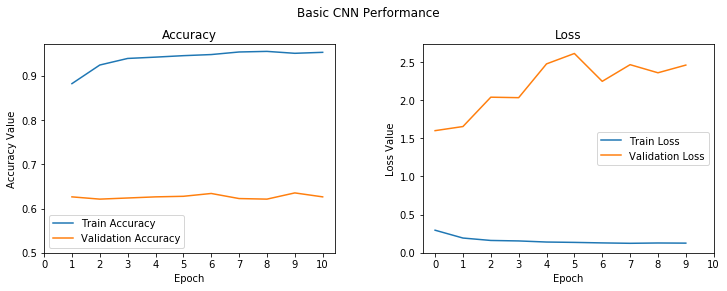

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,11))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 11, 1))
ax1.set_yticks(np.arange(.5, 1, .1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 11, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [31]:
X_mn_test=[]
y_mn_test=[]
img_size = 128

mn_normal_directory = Test+'NORMAL/'

for img in tqdm(os.listdir(mn_normal_directory)):
    label = 'Normal'
    path = os.path.join(mn_normal_directory,img)
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_size,img_size))

    X_mn_test.append(np.array(img))
    y_mn_test.append(str(label))

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:05<00:00, 45.51it/s]


In [32]:
mn_pneumonia_directory = Test+'PNEUMONIA/'

for img in tqdm(os.listdir(mn_pneumonia_directory)):
    label = 'Pneumonia'
    path = os.path.join(mn_pneumonia_directory,img)
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_size,img_size))

    X_mn_test.append(np.array(img))
    y_mn_test.append(str(label))

100%|███████████████████████████████████████████████████████████████████████████████| 390/390 [00:03<00:00, 122.66it/s]


In [40]:
labelEncoder=LabelEncoder()
y_mn_test=labelEncoder.fit_transform(y_mn_test)
y_mn_test=to_categorical(y_mn_test,2)
X_mn_test=np.array(X_mn_test)
X_mn_test=X_mn_test/255

In [41]:
score = mobilenet_model.evaluate(X_mn_test, y_mn_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 2.472281472228739
Test accuracy: 0.625


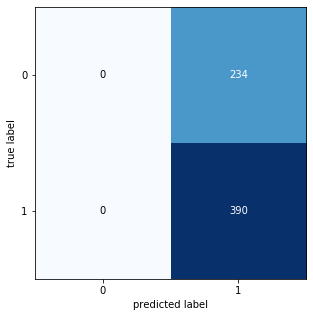

In [42]:
pred = mobilenet_model.predict(X_mn_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_mn_test,axis = 1)
CM = confusion_matrix(y_true, pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [43]:
# Precision Score
# precision = True Positive / (True Positive + False Positive)
print ("Precision Score: {}".format(CM[1][1] / (CM[1][1] + CM[0][1])))

# Recall Score
# recall = True Positive / (True Positive + False Negative)
print ("Recall Score: {}".format(CM[1][1] / (CM[1][1] + CM[1][0])))

Precision Score: 0.625
Recall Score: 1.0


# Summary